In [1]:
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import multiprocessing as mp
mp.set_start_method('spawn', force=True)

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, update_display, HTML

import io
import os
import json
import contextlib
from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)

import os # Force fully single-threaded
os.environ["OMP_NUM_THREADS"]    = "1"
os.environ["MKL_NUM_THREADS"]    = "1"
os.environ["NUMEXPR_NUM_THREADS"]= "1"

Running process_splits …
Reading data from intraday_stocks/AAPL_20040102_20250618.csv
Plotting original data...


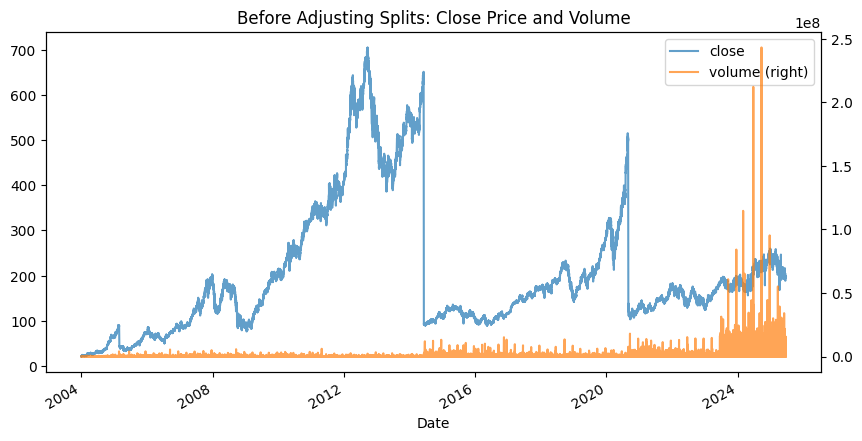

Detected forward split on 2014-06-09 08:00:00 with factor 7 (ratio: 0.1431)
Detected forward split on 2020-08-31 08:00:00 with factor 4 (ratio: 0.2510)
Splits detected. Plotting adjusted data...


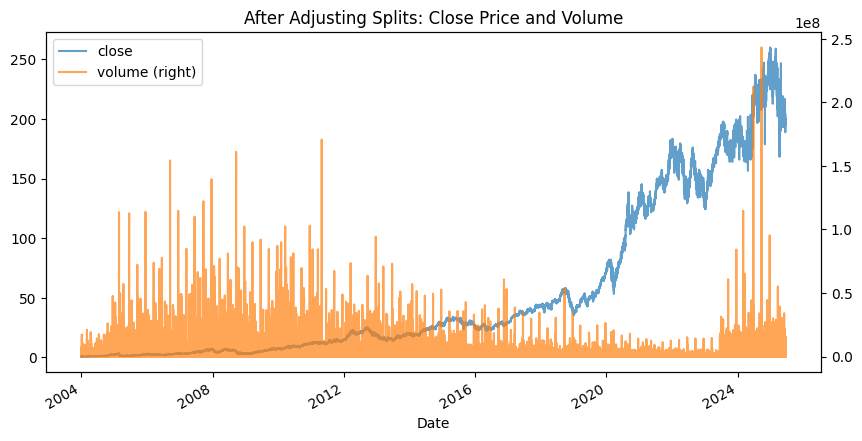

Running prepare_interpolate_data …
prepare_interpolate_data: removed 0 duplicate timestamps.
[process_splits] Saved processed data to: dfs_training/AAPL_1_base.csv


,open,high,low,close,volume,ask,bid
2004-01-02 11:30:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:31:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:32:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:33:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
2004-01-02 11:34:00,0.764286,0.764286,0.764286,0.764286,28000.0,0.764514,0.764057
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.0,196.874000,196.756000
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.0,196.734000,196.616000
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.0,196.729000,196.611000
2025-06-18 20:59:00,196.680000,196.750000,196.240000,196.240000,2075503.0,196.298900,196.181100


In [3]:
ticker         = params.ticker
save_path      = params.save_path
             
n_trials = 200
n_jobs = 1

base_csv = params.base_csv

print(f"Running process_splits …")
df_raw = trades.process_splits(
    folder                   = params.stocks_folder,
    ticker                   = ticker,
    bidasktoclose_spread     = params.bidasktoclose_spread
)

# Once‐only minute grid build and interpolation
print(f"Running prepare_interpolate_data …")
df = trades.prepare_interpolate_data(
    df                    = df_raw,
    regular_start_shifted = params.regular_start_shifted,
    regular_start         = params.regular_start,
    regular_end           = params.regular_end
)

# Persist to base CSV and return
df.to_csv(base_csv)
print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df,
    look_back,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    smooth_win_sig, 
    pre_entry_decay, 
    short_penalty,
    trailing_stop_thresh,
    buy_threshold
) -> float:
    """
    1) Compute median‐profit reference for this trial's thresholds.
    2) Run full backtest → one Strategy Return ($) per calendar day.
    3) Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
    4) Print both, return avg_daily_pnl to Optuna.
    """
    
    regular_start_pred = dt.time(*divmod(
        params.regular_start.hour * 60 + params.regular_start.minute - look_back,
        60
    ))
    regular_start_shifted = dt.time(*divmod(
        params.regular_start.hour * 60 + params.regular_start.minute - look_back*2,
        60
    ))

    # A) dynamic reference profit
    ref_profit = trades.compute_global_ref_profit(
        df,
        min_prof_thr            = min_prof_thr,
        max_down_prop           = max_down_prop,
        gain_tightening_factor  = gain_tightening_factor,
        merging_retracement_thr = merging_retracement_thr,
        merging_time_gap_thr    = merging_time_gap_thr,
        regular_start_pred      = regular_start_pred,
        regular_end             = params.regular_end
    )

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal_smooth',
        col_action               = 'signal_action',
        ref_profit               = ref_profit,
        smooth_win_sig           = smooth_win_sig,
        pre_entry_decay          = pre_entry_decay,
        short_penalty            = short_penalty,
        trailing_stop_thresh     = trailing_stop_thresh,
        buy_threshold            = buy_threshold,
        regular_start_shifted    = regular_start_shifted
    )

    # C) extract per-day stats
    per_day_stats = [stats for _, (_, _, stats) in simulation.items()]

    # free up every df_sim and trades_list before proceeding
    for _, (df_sim, trades_list, _) in simulation.items():
        del df_sim, trades_list
    del simulation
    gc.collect()

    # — use all trading days for the daily-P&L average —
    num_days      = trades.count_trading_days(df, params.regular_start, params.regular_end)
    daily_returns = [s["Strategy Return ($)"] for s in per_day_stats]
    total_pnl     = float(np.sum(daily_returns))
    avg_daily_pnl = total_pnl / num_days if num_days else 0.0

    # D) compute trade-level metrics on days with at least one trade
    trade_days_stats = [
        s for s in per_day_stats
        if s.get("Trades Returns ($)")
    ]
    total_trades  = sum(len(s["Trades Returns ($)"]) for s in trade_days_stats)
    avg_per_trade = total_pnl / total_trades if total_trades else 0.0

    # E) print detailed results
    print(f"→ Total return across {num_days} trading days: ${total_pnl:.2f}")
    print(f"→ Avg daily return (all days)          : ${avg_daily_pnl:.4f}")
    print(f"→ Total trades                          : {total_trades}")
    print(f"→ Avg return per trade                  : ${avg_per_trade:.4f}\n")

    return avg_daily_pnl


In [5]:
# calculate all possible look_backs, and create a list to use in the objective function,
# considering that it must be less than half time difference between regular_start and the first available timestamp

# 1) grab first timestamp’s time
first_ts = df.index.min()          # e.g. Timestamp('2004-01-02 11:30:00')
first_time = first_ts.time()       # → datetime.time(11, 30)

# 2) convert to minutes since midnight
first_minutes   = first_time.hour * 60 + first_time.minute
start_minutes   = params.regular_start.hour * 60 + params.regular_start.minute

# 3) compute half the interval
diff_minutes  = start_minutes - first_minutes         # e.g. 14:30 − 11:30 = 330
half_minutes  = diff_minutes / 2                      # → 165.0

# 4) how many full 30-min chunks fit below half_minutes?
n_steps = int(half_minutes // 30)                     # floor(165/30) = 5

# 5) build your list of multiples
look_backs = [30 * i for i in range(1, n_steps + 1)]   # → [30, 60, 90, 120, 150]

print(look_backs)


def objective(trial):
    hyperpars = {
        "look_back"               : trial.suggest_categorical("look_back", look_backs),
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.1, 0.7),
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 0.9),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 0.1, 0.9),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.1, 0.7),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 0.1, 0.7),
        "smooth_win_sig"          : trial.suggest_categorical("smooth_win_sig", [1,2,3,5,10,15,20,30]),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.1, 0.7),
        "short_penalty"           : trial.suggest_float("short_penalty", 0.01, 0.5),
        "trailing_stop_thresh"    : trial.suggest_float("trailing_stop_thresh", 0.01, 0.5),
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.05, 0.5),
    }

    print('---------------------------------------------------')
    #    This will print Total P&L and Average Daily P&L, and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


[30, 60, 90]


[I 2025-08-04 16:39:43,953] A new study created in RDB with name: no-name-96960ef7-50de-4268-ae8a-d22e943601ad


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1889.51
→ Avg daily return (all days)          : $0.3499
→ Total trades                          : 2380
→ Avg return per trade                  : $0.7939



[I 2025-08-04 16:44:04,709] Trial 0 finished with value: 0.3499094444444444 and parameters: {'look_back': 30, 'min_prof_thr': 0.376517293227027, 'max_down_prop': 0.5846251839686801, 'gain_tightening_factor': 0.13053134217724935, 'merging_retracement_thr': 0.10133281182150163, 'merging_time_gap_thr': 0.6779604866101698, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6747483317293793, 'short_penalty': 0.02554373404718208, 'trailing_stop_thresh': 0.29989526722249543, 'buy_threshold': 0.3716742588479689}. Best is trial 0 with value: 0.3499094444444444.


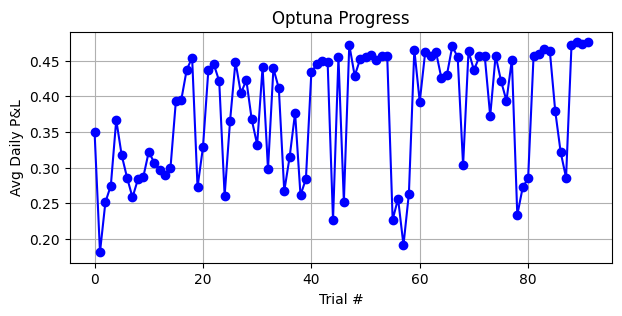

---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $978.82
→ Avg daily return (all days)          : $0.1813
→ Total trades                          : 3149
→ Avg return per trade                  : $0.3108



[I 2025-08-04 16:48:50,307] Trial 1 finished with value: 0.18126259259259256 and parameters: {'look_back': 30, 'min_prof_thr': 0.5574958225323225, 'max_down_prop': 0.19902868358980533, 'gain_tightening_factor': 0.8351598044842088, 'merging_retracement_thr': 0.18099569761242054, 'merging_time_gap_thr': 0.3053082283046721, 'smooth_win_sig': 15, 'pre_entry_decay': 0.5457943997134891, 'short_penalty': 0.4172328293250574, 'trailing_stop_thresh': 0.42521413370627265, 'buy_threshold': 0.07668575618205349}. Best is trial 0 with value: 0.3499094444444444.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1358.09
→ Avg daily return (all days)          : $0.2515
→ Total trades                          : 4410
→ Avg return per trade                  : $0.3080



[I 2025-08-04 16:54:37,256] Trial 2 finished with value: 0.251497962962963 and parameters: {'look_back': 90, 'min_prof_thr': 0.46222791299689503, 'max_down_prop': 0.10998615152471398, 'gain_tightening_factor': 0.12117350809913185, 'merging_retracement_thr': 0.3871440280075784, 'merging_time_gap_thr': 0.2342637955047363, 'smooth_win_sig': 5, 'pre_entry_decay': 0.44756992656603645, 'short_penalty': 0.18814945901384356, 'trailing_stop_thresh': 0.2502527941160687, 'buy_threshold': 0.09313248360432114}. Best is trial 0 with value: 0.3499094444444444.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1483.01
→ Avg daily return (all days)          : $0.2746
→ Total trades                          : 5572
→ Avg return per trade                  : $0.2662



[I 2025-08-04 16:59:57,646] Trial 3 finished with value: 0.2746309259259259 and parameters: {'look_back': 60, 'min_prof_thr': 0.146557403361879, 'max_down_prop': 0.23127340463199603, 'gain_tightening_factor': 0.7714929353861397, 'merging_retracement_thr': 0.5438733312190744, 'merging_time_gap_thr': 0.5000830042388041, 'smooth_win_sig': 5, 'pre_entry_decay': 0.3625010133009897, 'short_penalty': 0.12780205763268493, 'trailing_stop_thresh': 0.15545031900939962, 'buy_threshold': 0.08075117514268883}. Best is trial 0 with value: 0.3499094444444444.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1981.23
→ Avg daily return (all days)          : $0.3669
→ Total trades                          : 2456
→ Avg return per trade                  : $0.8067



[I 2025-08-04 17:05:06,671] Trial 4 finished with value: 0.36689518518518516 and parameters: {'look_back': 60, 'min_prof_thr': 0.5917436561185854, 'max_down_prop': 0.34221791388729256, 'gain_tightening_factor': 0.8350886952531006, 'merging_retracement_thr': 0.6342906466926591, 'merging_time_gap_thr': 0.143335628419696, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6082236825382453, 'short_penalty': 0.46977843087999077, 'trailing_stop_thresh': 0.19233479304324955, 'buy_threshold': 0.3110477148792834}. Best is trial 4 with value: 0.36689518518518516.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1714.76
→ Avg daily return (all days)          : $0.3175
→ Total trades                          : 1789
→ Avg return per trade                  : $0.9585



[I 2025-08-04 17:10:19,313] Trial 5 finished with value: 0.317547962962963 and parameters: {'look_back': 60, 'min_prof_thr': 0.5144115436411653, 'max_down_prop': 0.3911283217743228, 'gain_tightening_factor': 0.24140868275643765, 'merging_retracement_thr': 0.4211892663457695, 'merging_time_gap_thr': 0.645998646689314, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6302331006339492, 'short_penalty': 0.4625562122836826, 'trailing_stop_thresh': 0.3310565606677797, 'buy_threshold': 0.32688552039057184}. Best is trial 4 with value: 0.36689518518518516.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1543.22
→ Avg daily return (all days)          : $0.2858
→ Total trades                          : 3634
→ Avg return per trade                  : $0.4247



[I 2025-08-04 17:15:58,260] Trial 6 finished with value: 0.2857809259259259 and parameters: {'look_back': 90, 'min_prof_thr': 0.3929177484370727, 'max_down_prop': 0.8451613055114519, 'gain_tightening_factor': 0.12862155176062534, 'merging_retracement_thr': 0.6014653436499477, 'merging_time_gap_thr': 0.43140150057525983, 'smooth_win_sig': 15, 'pre_entry_decay': 0.49347574039103304, 'short_penalty': 0.052215723728298406, 'trailing_stop_thresh': 0.12232219067672137, 'buy_threshold': 0.1160801908965161}. Best is trial 4 with value: 0.36689518518518516.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1394.07
→ Avg daily return (all days)          : $0.2582
→ Total trades                          : 2376
→ Avg return per trade                  : $0.5867



[I 2025-08-04 17:21:22,737] Trial 7 finished with value: 0.2581614814814815 and parameters: {'look_back': 90, 'min_prof_thr': 0.6808672360099606, 'max_down_prop': 0.3333990217938781, 'gain_tightening_factor': 0.6530198893403459, 'merging_retracement_thr': 0.33681390661372873, 'merging_time_gap_thr': 0.14274031015779173, 'smooth_win_sig': 30, 'pre_entry_decay': 0.40361648685950213, 'short_penalty': 0.46137476381714854, 'trailing_stop_thresh': 0.20309584664241512, 'buy_threshold': 0.1647063606241561}. Best is trial 4 with value: 0.36689518518518516.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1530.82
→ Avg daily return (all days)          : $0.2835
→ Total trades                          : 1397
→ Avg return per trade                  : $1.0958



[I 2025-08-04 17:25:19,650] Trial 8 finished with value: 0.2834859259259259 and parameters: {'look_back': 30, 'min_prof_thr': 0.41944023253847307, 'max_down_prop': 0.7287563146208522, 'gain_tightening_factor': 0.47141354710411487, 'merging_retracement_thr': 0.20312448138565642, 'merging_time_gap_thr': 0.2265010600495294, 'smooth_win_sig': 1, 'pre_entry_decay': 0.30680395383853337, 'short_penalty': 0.387053602833036, 'trailing_stop_thresh': 0.42166862872250493, 'buy_threshold': 0.4442541121731742}. Best is trial 4 with value: 0.36689518518518516.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1550.23
→ Avg daily return (all days)          : $0.2871
→ Total trades                          : 1715
→ Avg return per trade                  : $0.9039



[I 2025-08-04 17:29:55,627] Trial 9 finished with value: 0.28707944444444444 and parameters: {'look_back': 60, 'min_prof_thr': 0.2723449739927931, 'max_down_prop': 0.2151382871031011, 'gain_tightening_factor': 0.5149282262006927, 'merging_retracement_thr': 0.5279045114305256, 'merging_time_gap_thr': 0.23152535941708943, 'smooth_win_sig': 5, 'pre_entry_decay': 0.5744384701112337, 'short_penalty': 0.48052097690781215, 'trailing_stop_thresh': 0.35066214921395455, 'buy_threshold': 0.4406682684250634}. Best is trial 4 with value: 0.36689518518518516.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1739.57
→ Avg daily return (all days)          : $0.3221
→ Total trades                          : 4334
→ Avg return per trade                  : $0.4014



[I 2025-08-04 17:35:18,161] Trial 10 finished with value: 0.32214203703703703 and parameters: {'look_back': 60, 'min_prof_thr': 0.681671946664024, 'max_down_prop': 0.5161932755271385, 'gain_tightening_factor': 0.6469696070415134, 'merging_retracement_thr': 0.6863989011427988, 'merging_time_gap_thr': 0.34982553146190704, 'smooth_win_sig': 3, 'pre_entry_decay': 0.12857846674901496, 'short_penalty': 0.3132012051284435, 'trailing_stop_thresh': 0.033238270371704404, 'buy_threshold': 0.2248733371356144}. Best is trial 4 with value: 0.36689518518518516.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1658.28
→ Avg daily return (all days)          : $0.3071
→ Total trades                          : 2277
→ Avg return per trade                  : $0.7283



[I 2025-08-04 17:40:25,952] Trial 11 finished with value: 0.3070883333333333 and parameters: {'look_back': 30, 'min_prof_thr': 0.3359585722667234, 'max_down_prop': 0.5878638267732591, 'gain_tightening_factor': 0.3372490721778655, 'merging_retracement_thr': 0.1182057303744583, 'merging_time_gap_thr': 0.6987438175696774, 'smooth_win_sig': 10, 'pre_entry_decay': 0.682648474889319, 'short_penalty': 0.014230259358942982, 'trailing_stop_thresh': 0.3099289143939486, 'buy_threshold': 0.3473169013302397}. Best is trial 4 with value: 0.36689518518518516.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1601.48
→ Avg daily return (all days)          : $0.2966
→ Total trades                          : 2075
→ Avg return per trade                  : $0.7718



[I 2025-08-04 17:45:13,517] Trial 12 finished with value: 0.2965705555555555 and parameters: {'look_back': 30, 'min_prof_thr': 0.2499676909315154, 'max_down_prop': 0.5964963143538117, 'gain_tightening_factor': 0.4168924457443831, 'merging_retracement_thr': 0.28276200702991927, 'merging_time_gap_thr': 0.5685201813704424, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6995882127543877, 'short_penalty': 0.2854611830970369, 'trailing_stop_thresh': 0.49894563355138144, 'buy_threshold': 0.35471313332010035}. Best is trial 4 with value: 0.36689518518518516.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1564.61
→ Avg daily return (all days)          : $0.2897
→ Total trades                          : 2416
→ Avg return per trade                  : $0.6476



[I 2025-08-04 17:50:41,437] Trial 13 finished with value: 0.28974259259259255 and parameters: {'look_back': 60, 'min_prof_thr': 0.5950689152842717, 'max_down_prop': 0.4164855367814342, 'gain_tightening_factor': 0.8792065007076834, 'merging_retracement_thr': 0.6960856242624937, 'merging_time_gap_thr': 0.10832289652374932, 'smooth_win_sig': 20, 'pre_entry_decay': 0.5941658221339662, 'short_penalty': 0.19124790984651857, 'trailing_stop_thresh': 0.0982416326205667, 'buy_threshold': 0.27485145966404106}. Best is trial 4 with value: 0.36689518518518516.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1613.11
→ Avg daily return (all days)          : $0.2987
→ Total trades                          : 1762
→ Avg return per trade                  : $0.9155



[I 2025-08-04 17:55:15,133] Trial 14 finished with value: 0.2987233333333334 and parameters: {'look_back': 30, 'min_prof_thr': 0.3449566465381072, 'max_down_prop': 0.6948638519833674, 'gain_tightening_factor': 0.6157580259283948, 'merging_retracement_thr': 0.44963786869125, 'merging_time_gap_thr': 0.4493849558552214, 'smooth_win_sig': 2, 'pre_entry_decay': 0.25229254365370907, 'short_penalty': 0.37174161188479377, 'trailing_stop_thresh': 0.23865826804669293, 'buy_threshold': 0.4974574985434498}. Best is trial 4 with value: 0.36689518518518516.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2122.27
→ Avg daily return (all days)          : $0.3930
→ Total trades                          : 2993
→ Avg return per trade                  : $0.7091



[I 2025-08-04 18:00:12,879] Trial 15 finished with value: 0.3930131481481482 and parameters: {'look_back': 60, 'min_prof_thr': 0.6030563832913023, 'max_down_prop': 0.4840685868349544, 'gain_tightening_factor': 0.332563891856965, 'merging_retracement_thr': 0.2676149565911169, 'merging_time_gap_thr': 0.5659221521314458, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6381261075558962, 'short_penalty': 0.10892033159333686, 'trailing_stop_thresh': 0.18289662731865372, 'buy_threshold': 0.27424099690672316}. Best is trial 15 with value: 0.3930131481481482.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2133.04
→ Avg daily return (all days)          : $0.3950
→ Total trades                          : 3520
→ Avg return per trade                  : $0.6060



[I 2025-08-04 18:05:05,670] Trial 16 finished with value: 0.3950072222222223 and parameters: {'look_back': 60, 'min_prof_thr': 0.5985713096667439, 'max_down_prop': 0.3277576079976763, 'gain_tightening_factor': 0.2910493370751429, 'merging_retracement_thr': 0.271834382351314, 'merging_time_gap_thr': 0.5816891962203043, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5033464870192513, 'short_penalty': 0.11276497137619092, 'trailing_stop_thresh': 0.188369562383375, 'buy_threshold': 0.2377792389035895}. Best is trial 16 with value: 0.3950072222222223.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2360.02
→ Avg daily return (all days)          : $0.4370
→ Total trades                          : 5383
→ Avg return per trade                  : $0.4384



[I 2025-08-04 18:09:56,778] Trial 17 finished with value: 0.4370414814814815 and parameters: {'look_back': 60, 'min_prof_thr': 0.6280730483932869, 'max_down_prop': 0.4651984784241977, 'gain_tightening_factor': 0.28406680303099285, 'merging_retracement_thr': 0.26617482190673075, 'merging_time_gap_thr': 0.5410935398700605, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5203010895399296, 'short_penalty': 0.11678287236658486, 'trailing_stop_thresh': 0.025482901785455814, 'buy_threshold': 0.22723940771386442}. Best is trial 17 with value: 0.4370414814814815.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2452.78
→ Avg daily return (all days)          : $0.4542
→ Total trades                          : 6197
→ Avg return per trade                  : $0.3958



[I 2025-08-04 18:14:49,016] Trial 18 finished with value: 0.45421833333333334 and parameters: {'look_back': 60, 'min_prof_thr': 0.48816794630703164, 'max_down_prop': 0.2992295010777144, 'gain_tightening_factor': 0.2627782916489729, 'merging_retracement_thr': 0.28759935990793345, 'merging_time_gap_thr': 0.5484748106930943, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5126516568636056, 'short_penalty': 0.18081148300828626, 'trailing_stop_thresh': 0.028945760841466217, 'buy_threshold': 0.19784072478529485}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1472.07
→ Avg daily return (all days)          : $0.2726
→ Total trades                          : 2930
→ Avg return per trade                  : $0.5024



[I 2025-08-04 18:19:38,105] Trial 19 finished with value: 0.27260574074074073 and parameters: {'look_back': 60, 'min_prof_thr': 0.4944929486548323, 'max_down_prop': 0.47450342889234215, 'gain_tightening_factor': 0.21736578608846716, 'merging_retracement_thr': 0.34556662274517636, 'merging_time_gap_thr': 0.5091572418457672, 'smooth_win_sig': 20, 'pre_entry_decay': 0.44700377427507565, 'short_penalty': 0.21871895692595858, 'trailing_stop_thresh': 0.016059734277618767, 'buy_threshold': 0.18382298386447557}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1772.57
→ Avg daily return (all days)          : $0.3283
→ Total trades                          : 4364
→ Avg return per trade                  : $0.4062



[I 2025-08-04 18:24:24,714] Trial 20 finished with value: 0.32825351851851853 and parameters: {'look_back': 60, 'min_prof_thr': 0.6923356015537423, 'max_down_prop': 0.11645216550556461, 'gain_tightening_factor': 0.39596664641557133, 'merging_retracement_thr': 0.19062755117829003, 'merging_time_gap_thr': 0.6067502346372933, 'smooth_win_sig': 10, 'pre_entry_decay': 0.5230632102692209, 'short_penalty': 0.15403973588900174, 'trailing_stop_thresh': 0.08347408755835475, 'buy_threshold': 0.1658273457635111}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2361.22
→ Avg daily return (all days)          : $0.4373
→ Total trades                          : 5084
→ Avg return per trade                  : $0.4644



[I 2025-08-04 18:29:08,198] Trial 21 finished with value: 0.4372637037037037 and parameters: {'look_back': 60, 'min_prof_thr': 0.6350245007203991, 'max_down_prop': 0.3103828920777487, 'gain_tightening_factor': 0.2381343286699723, 'merging_retracement_thr': 0.2686403817843285, 'merging_time_gap_thr': 0.5193844814328401, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4824604252761318, 'short_penalty': 0.07805220386714776, 'trailing_stop_thresh': 0.06372715771922549, 'buy_threshold': 0.22325970731785238}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2403.43
→ Avg daily return (all days)          : $0.4451
→ Total trades                          : 5680
→ Avg return per trade                  : $0.4231



[I 2025-08-04 18:33:59,792] Trial 22 finished with value: 0.4450790740740741 and parameters: {'look_back': 60, 'min_prof_thr': 0.6415220423404354, 'max_down_prop': 0.275278314478983, 'gain_tightening_factor': 0.22593596776864577, 'merging_retracement_thr': 0.23112955586950948, 'merging_time_gap_thr': 0.5093971051952458, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4482875572316669, 'short_penalty': 0.07609832039981065, 'trailing_stop_thresh': 0.049893762929112406, 'buy_threshold': 0.2139764279265143}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2273.96
→ Avg daily return (all days)          : $0.4211
→ Total trades                          : 5980
→ Avg return per trade                  : $0.3803



[I 2025-08-04 18:38:51,068] Trial 23 finished with value: 0.42110407407407413 and parameters: {'look_back': 60, 'min_prof_thr': 0.5314264266074281, 'max_down_prop': 0.273159160422717, 'gain_tightening_factor': 0.20838204145464997, 'merging_retracement_thr': 0.3299120613191676, 'merging_time_gap_thr': 0.47946192703973345, 'smooth_win_sig': 1, 'pre_entry_decay': 0.3524440613581938, 'short_penalty': 0.07154060313089658, 'trailing_stop_thresh': 0.0726784995660053, 'buy_threshold': 0.1380127372050514}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1406.67
→ Avg daily return (all days)          : $0.2605
→ Total trades                          : 2907
→ Avg return per trade                  : $0.4839



[I 2025-08-04 18:43:42,099] Trial 24 finished with value: 0.26049518518518516 and parameters: {'look_back': 60, 'min_prof_thr': 0.6399190286504117, 'max_down_prop': 0.17463987991640362, 'gain_tightening_factor': 0.18877389367537437, 'merging_retracement_thr': 0.20655844900873202, 'merging_time_gap_thr': 0.38306389301043414, 'smooth_win_sig': 30, 'pre_entry_decay': 0.4497372661696693, 'short_penalty': 0.07273211476649803, 'trailing_stop_thresh': 0.062202367869817116, 'buy_threshold': 0.200452506384311}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1972.83
→ Avg daily return (all days)          : $0.3653
→ Total trades                          : 3683
→ Avg return per trade                  : $0.5357



[I 2025-08-04 18:48:56,877] Trial 25 finished with value: 0.3653388888888889 and parameters: {'look_back': 90, 'min_prof_thr': 0.555685448088876, 'max_down_prop': 0.2795662006792285, 'gain_tightening_factor': 0.37586967294148194, 'merging_retracement_thr': 0.14657075512109963, 'merging_time_gap_thr': 0.6336846694589006, 'smooth_win_sig': 3, 'pre_entry_decay': 0.40546529256185043, 'short_penalty': 0.2501548036197016, 'trailing_stop_thresh': 0.13161611175878893, 'buy_threshold': 0.253153738302359}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2421.95
→ Avg daily return (all days)          : $0.4485
→ Total trades                          : 5978
→ Avg return per trade                  : $0.4051



[I 2025-08-04 18:53:50,518] Trial 26 finished with value: 0.448509074074074 and parameters: {'look_back': 60, 'min_prof_thr': 0.4470641928464578, 'max_down_prop': 0.2793593451124699, 'gain_tightening_factor': 0.5204052773591831, 'merging_retracement_thr': 0.24194839231553944, 'merging_time_gap_thr': 0.5321782639890392, 'smooth_win_sig': 1, 'pre_entry_decay': 0.47128931423979464, 'short_penalty': 0.16910315013657726, 'trailing_stop_thresh': 0.046909049133428825, 'buy_threshold': 0.19949574241638512}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2181.64
→ Avg daily return (all days)          : $0.4040
→ Total trades                          : 4608
→ Avg return per trade                  : $0.4734



[I 2025-08-04 18:58:41,227] Trial 27 finished with value: 0.4040064814814815 and parameters: {'look_back': 60, 'min_prof_thr': 0.43049185242622373, 'max_down_prop': 0.3829043382246108, 'gain_tightening_factor': 0.5395656108056113, 'merging_retracement_thr': 0.23012203978280737, 'merging_time_gap_thr': 0.45573402358999626, 'smooth_win_sig': 1, 'pre_entry_decay': 0.26903414196356956, 'short_penalty': 0.17710213279060222, 'trailing_stop_thresh': 0.1127660241329134, 'buy_threshold': 0.1903877236270243}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2283.29
→ Avg daily return (all days)          : $0.4228
→ Total trades                          : 8528
→ Avg return per trade                  : $0.2677



[I 2025-08-04 19:03:31,610] Trial 28 finished with value: 0.4228311111111111 and parameters: {'look_back': 60, 'min_prof_thr': 0.4645027927783072, 'max_down_prop': 0.16928290891825065, 'gain_tightening_factor': 0.45619235173989936, 'merging_retracement_thr': 0.15344480327933424, 'merging_time_gap_thr': 0.42096217524893187, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5572754461764041, 'short_penalty': 0.2270367667771587, 'trailing_stop_thresh': 0.04657424646731065, 'buy_threshold': 0.050333872578043726}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1984.24
→ Avg daily return (all days)          : $0.3675
→ Total trades                          : 4866
→ Avg return per trade                  : $0.4078



[I 2025-08-04 19:08:54,667] Trial 29 finished with value: 0.36745222222222224 and parameters: {'look_back': 90, 'min_prof_thr': 0.34012864360637485, 'max_down_prop': 0.2524420616714236, 'gain_tightening_factor': 0.5938987045583092, 'merging_retracement_thr': 0.1025527780390354, 'merging_time_gap_thr': 0.6375729323447793, 'smooth_win_sig': 1, 'pre_entry_decay': 0.36006616383852563, 'short_penalty': 0.15192534078548744, 'trailing_stop_thresh': 0.1610374998032473, 'buy_threshold': 0.14218713794967408}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1793.57
→ Avg daily return (all days)          : $0.3321
→ Total trades                          : 4812
→ Avg return per trade                  : $0.3727



[I 2025-08-04 19:13:48,860] Trial 30 finished with value: 0.3321427777777778 and parameters: {'look_back': 60, 'min_prof_thr': 0.4847120171245933, 'max_down_prop': 0.4121065120768802, 'gain_tightening_factor': 0.18118029321517015, 'merging_retracement_thr': 0.3111212060696299, 'merging_time_gap_thr': 0.48052159675372264, 'smooth_win_sig': 3, 'pre_entry_decay': 0.1953282361676945, 'short_penalty': 0.037725631245078745, 'trailing_stop_thresh': 0.019760278071064424, 'buy_threshold': 0.2964170710202114}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2381.03
→ Avg daily return (all days)          : $0.4409
→ Total trades                          : 5297
→ Avg return per trade                  : $0.4495



[I 2025-08-04 19:18:45,741] Trial 31 finished with value: 0.44093185185185185 and parameters: {'look_back': 60, 'min_prof_thr': 0.6530702758723297, 'max_down_prop': 0.297246450338327, 'gain_tightening_factor': 0.27261012434200593, 'merging_retracement_thr': 0.2322670481400225, 'merging_time_gap_thr': 0.5263067657885374, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4728567875511327, 'short_penalty': 0.08588436614055014, 'trailing_stop_thresh': 0.06312961384750113, 'buy_threshold': 0.20972944696144602}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1607.26
→ Avg daily return (all days)          : $0.2976
→ Total trades                          : 3479
→ Avg return per trade                  : $0.4620



[I 2025-08-04 19:23:59,725] Trial 32 finished with value: 0.2976403703703704 and parameters: {'look_back': 60, 'min_prof_thr': 0.5406701826468321, 'max_down_prop': 0.1886761360726964, 'gain_tightening_factor': 0.28627820056227515, 'merging_retracement_thr': 0.22553081868208463, 'merging_time_gap_thr': 0.5422692509923766, 'smooth_win_sig': 15, 'pre_entry_decay': 0.4684372975401027, 'short_penalty': 0.15026187575797048, 'trailing_stop_thresh': 0.0920112199219257, 'buy_threshold': 0.20486868703820948}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2370.55
→ Avg daily return (all days)          : $0.4390
→ Total trades                          : 6249
→ Avg return per trade                  : $0.3793



[I 2025-08-04 19:29:02,607] Trial 33 finished with value: 0.43899055555555555 and parameters: {'look_back': 60, 'min_prof_thr': 0.4545036472142546, 'max_down_prop': 0.29394071461240523, 'gain_tightening_factor': 0.16622297858733412, 'merging_retracement_thr': 0.36394794415354936, 'merging_time_gap_thr': 0.6090536013346555, 'smooth_win_sig': 1, 'pre_entry_decay': 0.42959975510347115, 'short_penalty': 0.09667660761650465, 'trailing_stop_thresh': 0.05482352921797712, 'buy_threshold': 0.14336302434014164}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2220.51
→ Avg daily return (all days)          : $0.4112
→ Total trades                          : 4190
→ Avg return per trade                  : $0.5300



[I 2025-08-04 19:33:30,682] Trial 34 finished with value: 0.4112048148148148 and parameters: {'look_back': 60, 'min_prof_thr': 0.5660169258598589, 'max_down_prop': 0.12837124668897204, 'gain_tightening_factor': 0.33938761612096213, 'merging_retracement_thr': 0.3032628865617253, 'merging_time_gap_thr': 0.39291244561154226, 'smooth_win_sig': 1, 'pre_entry_decay': 0.416594787193795, 'short_penalty': 0.21290073988797997, 'trailing_stop_thresh': 0.13259036541201122, 'buy_threshold': 0.26176986319815393}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1440.84
→ Avg daily return (all days)          : $0.2668
→ Total trades                          : 3850
→ Avg return per trade                  : $0.3742



[I 2025-08-04 19:38:19,433] Trial 35 finished with value: 0.26682148148148144 and parameters: {'look_back': 60, 'min_prof_thr': 0.2895381878183564, 'max_down_prop': 0.3632282651668051, 'gain_tightening_factor': 0.10872912252611469, 'merging_retracement_thr': 0.16256509422791818, 'merging_time_gap_thr': 0.333120062943417, 'smooth_win_sig': 20, 'pre_entry_decay': 0.5470429920584507, 'short_penalty': 0.14181157640507336, 'trailing_stop_thresh': 0.016775644453074313, 'buy_threshold': 0.10899928064786289}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1701.52
→ Avg daily return (all days)          : $0.3151
→ Total trades                          : 4533
→ Avg return per trade                  : $0.3754



[I 2025-08-04 19:43:17,667] Trial 36 finished with value: 0.31509666666666664 and parameters: {'look_back': 60, 'min_prof_thr': 0.21645155200668237, 'max_down_prop': 0.2523756451101017, 'gain_tightening_factor': 0.549187469166626, 'merging_retracement_thr': 0.24493003609620195, 'merging_time_gap_thr': 0.535336437454234, 'smooth_win_sig': 5, 'pre_entry_decay': 0.3574153704826263, 'short_penalty': 0.18031627172153566, 'trailing_stop_thresh': 0.1524365914658829, 'buy_threshold': 0.16475683816896267}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2034.20
→ Avg daily return (all days)          : $0.3767
→ Total trades                          : 3319
→ Avg return per trade                  : $0.6129



[I 2025-08-04 19:48:39,418] Trial 37 finished with value: 0.37670462962962964 and parameters: {'look_back': 90, 'min_prof_thr': 0.3733684848462104, 'max_down_prop': 0.434336387887587, 'gain_tightening_factor': 0.7555219170033829, 'merging_retracement_thr': 0.38210089817316306, 'merging_time_gap_thr': 0.48423772790120234, 'smooth_win_sig': 2, 'pre_entry_decay': 0.46844468468292794, 'short_penalty': 0.047452434159678494, 'trailing_stop_thresh': 0.2273782032650303, 'buy_threshold': 0.30197974465473265}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1409.95
→ Avg daily return (all days)          : $0.2611
→ Total trades                          : 2496
→ Avg return per trade                  : $0.5649



[I 2025-08-04 19:53:16,443] Trial 38 finished with value: 0.2611024074074074 and parameters: {'look_back': 30, 'min_prof_thr': 0.666335362226305, 'max_down_prop': 0.2129647570198719, 'gain_tightening_factor': 0.41927330607438107, 'merging_retracement_thr': 0.4210394414576099, 'merging_time_gap_thr': 0.6629080436819639, 'smooth_win_sig': 30, 'pre_entry_decay': 0.38107414241454446, 'short_penalty': 0.2842877621670059, 'trailing_stop_thresh': 0.09961613596693215, 'buy_threshold': 0.21096562315993964}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1535.03
→ Avg daily return (all days)          : $0.2843
→ Total trades                          : 3875
→ Avg return per trade                  : $0.3961



[I 2025-08-04 19:58:13,135] Trial 39 finished with value: 0.28426555555555555 and parameters: {'look_back': 60, 'min_prof_thr': 0.10532434577924027, 'max_down_prop': 0.5338735840618165, 'gain_tightening_factor': 0.2566495692674929, 'merging_retracement_thr': 0.4710999172100852, 'merging_time_gap_thr': 0.5760773546911322, 'smooth_win_sig': 15, 'pre_entry_decay': 0.32106731847077197, 'short_penalty': 0.09706066753585807, 'trailing_stop_thresh': 0.04995209117595213, 'buy_threshold': 0.2547362669260007}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2341.44
→ Avg daily return (all days)          : $0.4336
→ Total trades                          : 5951
→ Avg return per trade                  : $0.3935



[I 2025-08-04 20:03:04,922] Trial 40 finished with value: 0.43360037037037036 and parameters: {'look_back': 60, 'min_prof_thr': 0.5079476550101037, 'max_down_prop': 0.3542822400935559, 'gain_tightening_factor': 0.14574958212412256, 'merging_retracement_thr': 0.3057020901671775, 'merging_time_gap_thr': 0.6087871709412072, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5205444275338549, 'short_penalty': 0.015142536634308701, 'trailing_stop_thresh': 0.07732252050624987, 'buy_threshold': 0.12385616363406833}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2404.19
→ Avg daily return (all days)          : $0.4452
→ Total trades                          : 6176
→ Avg return per trade                  : $0.3893



[I 2025-08-04 20:07:56,316] Trial 41 finished with value: 0.445220925925926 and parameters: {'look_back': 60, 'min_prof_thr': 0.4298169846120513, 'max_down_prop': 0.3038163311743992, 'gain_tightening_factor': 0.15590377755993937, 'merging_retracement_thr': 0.3820891355322514, 'merging_time_gap_thr': 0.6086438712869422, 'smooth_win_sig': 1, 'pre_entry_decay': 0.43085235195113675, 'short_penalty': 0.09090981377233805, 'trailing_stop_thresh': 0.04705089589468504, 'buy_threshold': 0.17127315915884836}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2429.18
→ Avg daily return (all days)          : $0.4498
→ Total trades                          : 6733
→ Avg return per trade                  : $0.3608



[I 2025-08-04 20:12:47,271] Trial 42 finished with value: 0.449849074074074 and parameters: {'look_back': 60, 'min_prof_thr': 0.4286331110059816, 'max_down_prop': 0.23761745918566468, 'gain_tightening_factor': 0.11229696187591418, 'merging_retracement_thr': 0.24009864998978364, 'merging_time_gap_thr': 0.5119023227573726, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4411581757675573, 'short_penalty': 0.058073848736320766, 'trailing_stop_thresh': 0.03833488063593252, 'buy_threshold': 0.1786853872344972}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2422.99
→ Avg daily return (all days)          : $0.4487
→ Total trades                          : 6547
→ Avg return per trade                  : $0.3701



[I 2025-08-04 20:17:41,743] Trial 43 finished with value: 0.4487022222222223 and parameters: {'look_back': 60, 'min_prof_thr': 0.4093230588965877, 'max_down_prop': 0.23213767494164975, 'gain_tightening_factor': 0.10398303060759169, 'merging_retracement_thr': 0.39978751928224887, 'merging_time_gap_thr': 0.6819028486952778, 'smooth_win_sig': 1, 'pre_entry_decay': 0.4425671072495034, 'short_penalty': 0.06135239661145764, 'trailing_stop_thresh': 0.043372220375556304, 'buy_threshold': 0.16870340501986306}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1221.96
→ Avg daily return (all days)          : $0.2263
→ Total trades                          : 4132
→ Avg return per trade                  : $0.2957



[I 2025-08-04 20:22:34,743] Trial 44 finished with value: 0.22628888888888885 and parameters: {'look_back': 60, 'min_prof_thr': 0.4162997229394629, 'max_down_prop': 0.15577477582196225, 'gain_tightening_factor': 0.10015799264427175, 'merging_retracement_thr': 0.4698893925284156, 'merging_time_gap_thr': 0.6969531693031074, 'smooth_win_sig': 10, 'pre_entry_decay': 0.39591132103997545, 'short_penalty': 0.049444905156596115, 'trailing_stop_thresh': 0.26601219283805266, 'buy_threshold': 0.08166499489648861}. Best is trial 18 with value: 0.45421833333333334.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2454.48
→ Avg daily return (all days)          : $0.4545
→ Total trades                          : 6342
→ Avg return per trade                  : $0.3870



[I 2025-08-04 20:27:52,185] Trial 45 finished with value: 0.4545335185185186 and parameters: {'look_back': 90, 'min_prof_thr': 0.3805569818259982, 'max_down_prop': 0.2418679239385966, 'gain_tightening_factor': 0.16106862345000658, 'merging_retracement_thr': 0.40347625739279264, 'merging_time_gap_thr': 0.6424183894463131, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5033739607506575, 'short_penalty': 0.1320533074330243, 'trailing_stop_thresh': 0.04030956747797385, 'buy_threshold': 0.17880624421800517}. Best is trial 45 with value: 0.4545335185185186.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1360.73
→ Avg daily return (all days)          : $0.2520
→ Total trades                          : 3029
→ Avg return per trade                  : $0.4492



[I 2025-08-04 20:33:09,271] Trial 46 finished with value: 0.2519864814814815 and parameters: {'look_back': 90, 'min_prof_thr': 0.37961490294195377, 'max_down_prop': 0.22411220882082922, 'gain_tightening_factor': 0.7235061802294337, 'merging_retracement_thr': 0.4232864061743888, 'merging_time_gap_thr': 0.6510930781835973, 'smooth_win_sig': 5, 'pre_entry_decay': 0.5707796279894435, 'short_penalty': 0.13549418636940191, 'trailing_stop_thresh': 0.3912582757460713, 'buy_threshold': 0.18197596400206753}. Best is trial 45 with value: 0.4545335185185186.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2550.11
→ Avg daily return (all days)          : $0.4722
→ Total trades                          : 8144
→ Avg return per trade                  : $0.3131



[I 2025-08-04 20:38:25,428] Trial 47 finished with value: 0.47224259259259255 and parameters: {'look_back': 90, 'min_prof_thr': 0.3086391992304369, 'max_down_prop': 0.8837969987467448, 'gain_tightening_factor': 0.12618125913659636, 'merging_retracement_thr': 0.5261772957610087, 'merging_time_gap_thr': 0.6842877814709137, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6290069594268448, 'short_penalty': 0.1936000926827041, 'trailing_stop_thresh': 0.010347450519371214, 'buy_threshold': 0.09695743635180956}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2314.66
→ Avg daily return (all days)          : $0.4286
→ Total trades                          : 5568
→ Avg return per trade                  : $0.4157



[I 2025-08-04 20:43:38,712] Trial 48 finished with value: 0.42864092592592595 and parameters: {'look_back': 90, 'min_prof_thr': 0.31253559526715263, 'max_down_prop': 0.8819702248704482, 'gain_tightening_factor': 0.13157682530313705, 'merging_retracement_thr': 0.5516793290299397, 'merging_time_gap_thr': 0.6752745135762124, 'smooth_win_sig': 2, 'pre_entry_decay': 0.6412529199524076, 'short_penalty': 0.2434457074492309, 'trailing_stop_thresh': 0.11329000194289007, 'buy_threshold': 0.1039463616799542}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2441.17
→ Avg daily return (all days)          : $0.4521
→ Total trades                          : 9441
→ Avg return per trade                  : $0.2586



[I 2025-08-04 20:48:52,143] Trial 49 finished with value: 0.45206907407407404 and parameters: {'look_back': 90, 'min_prof_thr': 0.21887120147829683, 'max_down_prop': 0.7536358063342279, 'gain_tightening_factor': 0.13616617246880008, 'merging_retracement_thr': 0.5449708635473174, 'merging_time_gap_thr': 0.6755351829487412, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5816366217077992, 'short_penalty': 0.20334885294765956, 'trailing_stop_thresh': 0.010302439958325655, 'buy_threshold': 0.05626126958694594}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2453.87
→ Avg daily return (all days)          : $0.4544
→ Total trades                          : 9373
→ Avg return per trade                  : $0.2618



[I 2025-08-04 20:54:08,699] Trial 50 finished with value: 0.45441962962962973 and parameters: {'look_back': 90, 'min_prof_thr': 0.20833151122399776, 'max_down_prop': 0.7744912906956304, 'gain_tightening_factor': 0.18385233384276434, 'merging_retracement_thr': 0.5899496443043782, 'merging_time_gap_thr': 0.633139843142525, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6160499845608481, 'short_penalty': 0.20295157234037273, 'trailing_stop_thresh': 0.011685131811666444, 'buy_threshold': 0.05889154907015949}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2471.95
→ Avg daily return (all days)          : $0.4578
→ Total trades                          : 9090
→ Avg return per trade                  : $0.2719



[I 2025-08-04 20:59:27,507] Trial 51 finished with value: 0.45776944444444445 and parameters: {'look_back': 90, 'min_prof_thr': 0.2329366952415616, 'max_down_prop': 0.8102322709838524, 'gain_tightening_factor': 0.18233241942658213, 'merging_retracement_thr': 0.6012586177070546, 'merging_time_gap_thr': 0.628094574243676, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6191996157299577, 'short_penalty': 0.19768357043635482, 'trailing_stop_thresh': 0.010152679739182751, 'buy_threshold': 0.06418335642897835}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2437.60
→ Avg daily return (all days)          : $0.4514
→ Total trades                          : 9617
→ Avg return per trade                  : $0.2535



[I 2025-08-04 21:04:43,295] Trial 52 finished with value: 0.45140648148148155 and parameters: {'look_back': 90, 'min_prof_thr': 0.20250887180168683, 'max_down_prop': 0.7809214716673613, 'gain_tightening_factor': 0.19111017587049642, 'merging_retracement_thr': 0.6003690989302288, 'merging_time_gap_thr': 0.6293494763690486, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6096542008438725, 'short_penalty': 0.20112496616239373, 'trailing_stop_thresh': 0.010219551926143206, 'buy_threshold': 0.054744743213104415}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2463.93
→ Avg daily return (all days)          : $0.4563
→ Total trades                          : 8431
→ Avg return per trade                  : $0.2922



[I 2025-08-04 21:09:59,809] Trial 53 finished with value: 0.4562835185185185 and parameters: {'look_back': 90, 'min_prof_thr': 0.1735543214513639, 'max_down_prop': 0.8257562449153271, 'gain_tightening_factor': 0.17150132867652185, 'merging_retracement_thr': 0.6552388110134609, 'merging_time_gap_thr': 0.6651359839105556, 'smooth_win_sig': 1, 'pre_entry_decay': 0.668753493823605, 'short_penalty': 0.2800811015902317, 'trailing_stop_thresh': 0.023851319082628497, 'buy_threshold': 0.07399313492110435}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2463.56
→ Avg daily return (all days)          : $0.4562
→ Total trades                          : 8192
→ Avg return per trade                  : $0.3007



[I 2025-08-04 21:15:17,901] Trial 54 finished with value: 0.45621518518518517 and parameters: {'look_back': 90, 'min_prof_thr': 0.1793430442373514, 'max_down_prop': 0.8231754953580934, 'gain_tightening_factor': 0.17418074346174295, 'merging_retracement_thr': 0.6605115566891733, 'merging_time_gap_thr': 0.26870419547987456, 'smooth_win_sig': 1, 'pre_entry_decay': 0.660706718183574, 'short_penalty': 0.2776424206883771, 'trailing_stop_thresh': 0.02815088558154053, 'buy_threshold': 0.07787292161051564}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1224.75
→ Avg daily return (all days)          : $0.2268
→ Total trades                          : 3463
→ Avg return per trade                  : $0.3537



[I 2025-08-04 21:20:34,931] Trial 55 finished with value: 0.22680629629629628 and parameters: {'look_back': 90, 'min_prof_thr': 0.1746045014524053, 'max_down_prop': 0.8310900517970344, 'gain_tightening_factor': 0.16863109721575859, 'merging_retracement_thr': 0.653404441136444, 'merging_time_gap_thr': 0.2582991101225729, 'smooth_win_sig': 30, 'pre_entry_decay': 0.6562848972287799, 'short_penalty': 0.3451757894970611, 'trailing_stop_thresh': 0.08258022703539353, 'buy_threshold': 0.07853608647783594}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1384.50
→ Avg daily return (all days)          : $0.2564
→ Total trades                          : 4817
→ Avg return per trade                  : $0.2874



[I 2025-08-04 21:25:53,222] Trial 56 finished with value: 0.2563892592592592 and parameters: {'look_back': 90, 'min_prof_thr': 0.1398852996380659, 'max_down_prop': 0.6719943237357526, 'gain_tightening_factor': 0.30927094889488327, 'merging_retracement_thr': 0.6001682533425722, 'merging_time_gap_thr': 0.2744116487618124, 'smooth_win_sig': 15, 'pre_entry_decay': 0.6752705500164916, 'short_penalty': 0.3042482075580848, 'trailing_stop_thresh': 0.031491719907934715, 'buy_threshold': 0.06940413706482791}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1033.42
→ Avg daily return (all days)          : $0.1914
→ Total trades                          : 3018
→ Avg return per trade                  : $0.3424



[I 2025-08-04 21:31:11,276] Trial 57 finished with value: 0.1913738888888889 and parameters: {'look_back': 90, 'min_prof_thr': 0.2491974660036477, 'max_down_prop': 0.8153340359772885, 'gain_tightening_factor': 0.21364097159396728, 'merging_retracement_thr': 0.6361491581453937, 'merging_time_gap_thr': 0.1851362906223356, 'smooth_win_sig': 10, 'pre_entry_decay': 0.6191380176942171, 'short_penalty': 0.2650433778465198, 'trailing_stop_thresh': 0.4861785243557633, 'buy_threshold': 0.0938225820485887}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1423.43
→ Avg daily return (all days)          : $0.2636
→ Total trades                          : 3880
→ Avg return per trade                  : $0.3669



[I 2025-08-04 21:36:29,129] Trial 58 finished with value: 0.2635983333333333 and parameters: {'look_back': 90, 'min_prof_thr': 0.16813285950100978, 'max_down_prop': 0.8831255036329206, 'gain_tightening_factor': 0.24379991220280306, 'merging_retracement_thr': 0.6690473446229601, 'merging_time_gap_thr': 0.5899123888790775, 'smooth_win_sig': 20, 'pre_entry_decay': 0.659829808621588, 'short_penalty': 0.3214077892440229, 'trailing_stop_thresh': 0.07187370674853971, 'buy_threshold': 0.09440200233276064}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2512.62
→ Avg daily return (all days)          : $0.4653
→ Total trades                          : 7085
→ Avg return per trade                  : $0.3546



[I 2025-08-04 21:41:46,304] Trial 59 finished with value: 0.46530000000000005 and parameters: {'look_back': 90, 'min_prof_thr': 0.25971226049199037, 'max_down_prop': 0.7975226946715492, 'gain_tightening_factor': 0.20094245758289114, 'merging_retracement_thr': 0.57367585991979, 'merging_time_gap_thr': 0.6525159595003391, 'smooth_win_sig': 1, 'pre_entry_decay': 0.596698400465724, 'short_penalty': 0.23382815744136465, 'trailing_stop_thresh': 0.030430717852675496, 'buy_threshold': 0.12697984520525665}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2118.41
→ Avg daily return (all days)          : $0.3923
→ Total trades                          : 6252
→ Avg return per trade                  : $0.3388



[I 2025-08-04 21:46:59,463] Trial 60 finished with value: 0.3922974074074075 and parameters: {'look_back': 90, 'min_prof_thr': 0.2536343850263779, 'max_down_prop': 0.6630352339318987, 'gain_tightening_factor': 0.1477213712262819, 'merging_retracement_thr': 0.5681560973368238, 'merging_time_gap_thr': 0.6567282590318656, 'smooth_win_sig': 3, 'pre_entry_decay': 0.6896925576610561, 'short_penalty': 0.2685894683919619, 'trailing_stop_thresh': 0.0334668232103776, 'buy_threshold': 0.1254821291237201}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2491.64
→ Avg daily return (all days)          : $0.4614
→ Total trades                          : 7828
→ Avg return per trade                  : $0.3183



[I 2025-08-04 21:52:14,600] Trial 61 finished with value: 0.4614157407407407 and parameters: {'look_back': 90, 'min_prof_thr': 0.29278400163122503, 'max_down_prop': 0.7956406782888961, 'gain_tightening_factor': 0.19951872877211513, 'merging_retracement_thr': 0.5136573529552311, 'merging_time_gap_thr': 0.6942470793559853, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6048517002306526, 'short_penalty': 0.23465589004333912, 'trailing_stop_thresh': 0.02718821956234442, 'buy_threshold': 0.07810961387086865}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2465.65
→ Avg daily return (all days)          : $0.4566
→ Total trades                          : 7470
→ Avg return per trade                  : $0.3301



[I 2025-08-04 21:57:29,227] Trial 62 finished with value: 0.45660185185185187 and parameters: {'look_back': 90, 'min_prof_thr': 0.30253681578649827, 'max_down_prop': 0.8122808714665803, 'gain_tightening_factor': 0.22291053544544565, 'merging_retracement_thr': 0.5202748190158599, 'merging_time_gap_thr': 0.6821375144950447, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5894944658619931, 'short_penalty': 0.2293292724471248, 'trailing_stop_thresh': 0.036548157223750585, 'buy_threshold': 0.07913284439828336}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2495.58
→ Avg daily return (all days)          : $0.4621
→ Total trades                          : 7874
→ Avg return per trade                  : $0.3169



[I 2025-08-04 22:02:47,548] Trial 63 finished with value: 0.4621435185185186 and parameters: {'look_back': 90, 'min_prof_thr': 0.29219809503234645, 'max_down_prop': 0.8568553400911035, 'gain_tightening_factor': 0.20596708418841875, 'merging_retracement_thr': 0.5130581478247971, 'merging_time_gap_thr': 0.6980100339845172, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6460070012563426, 'short_penalty': 0.24062135110328897, 'trailing_stop_thresh': 0.02880080887846341, 'buy_threshold': 0.07105156028693838}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2296.65
→ Avg daily return (all days)          : $0.4253
→ Total trades                          : 5730
→ Avg return per trade                  : $0.4008



[I 2025-08-04 22:08:07,046] Trial 64 finished with value: 0.42530574074074073 and parameters: {'look_back': 90, 'min_prof_thr': 0.302544302955509, 'max_down_prop': 0.7296450013947, 'gain_tightening_factor': 0.21054612321186922, 'merging_retracement_thr': 0.4925261596858181, 'merging_time_gap_thr': 0.6992215272885739, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5923405115784868, 'short_penalty': 0.24532340950668022, 'trailing_stop_thresh': 0.09588424645042098, 'buy_threshold': 0.09546047013800386}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2318.71
→ Avg daily return (all days)          : $0.4294
→ Total trades                          : 6797
→ Avg return per trade                  : $0.3411



[I 2025-08-04 22:13:25,979] Trial 65 finished with value: 0.42939000000000005 and parameters: {'look_back': 90, 'min_prof_thr': 0.27270283218072744, 'max_down_prop': 0.8570650583085042, 'gain_tightening_factor': 0.3088191378904035, 'merging_retracement_thr': 0.5220030673304982, 'merging_time_gap_thr': 0.670197225448962, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6463575853226194, 'short_penalty': 0.23120599827055455, 'trailing_stop_thresh': 0.07060153066809459, 'buy_threshold': 0.0676798534920797}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2538.77
→ Avg daily return (all days)          : $0.4701
→ Total trades                          : 6873
→ Avg return per trade                  : $0.3694



[I 2025-08-04 22:18:44,574] Trial 66 finished with value: 0.47014222222222213 and parameters: {'look_back': 90, 'min_prof_thr': 0.31995601342940677, 'max_down_prop': 0.896876683413261, 'gain_tightening_factor': 0.24546088182155318, 'merging_retracement_thr': 0.5130418401442243, 'merging_time_gap_thr': 0.6918718123884466, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6287726157469877, 'short_penalty': 0.23064738958980185, 'trailing_stop_thresh': 0.029896578716991733, 'buy_threshold': 0.11789557628419477}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2457.03
→ Avg daily return (all days)          : $0.4550
→ Total trades                          : 6079
→ Avg return per trade                  : $0.4042



[I 2025-08-04 22:24:03,811] Trial 67 finished with value: 0.4550064814814814 and parameters: {'look_back': 90, 'min_prof_thr': 0.3170536403567534, 'max_down_prop': 0.7960174459732623, 'gain_tightening_factor': 0.24141029685089777, 'merging_retracement_thr': 0.5160906331595783, 'merging_time_gap_thr': 0.6873939391731626, 'smooth_win_sig': 1, 'pre_entry_decay': 0.629856267411341, 'short_penalty': 0.2391996914403597, 'trailing_stop_thresh': 0.061450154946418784, 'buy_threshold': 0.11717520982737879}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1635.92
→ Avg daily return (all days)          : $0.3029
→ Total trades                          : 3242
→ Avg return per trade                  : $0.5046



[I 2025-08-04 22:29:18,786] Trial 68 finished with value: 0.30294740740740744 and parameters: {'look_back': 90, 'min_prof_thr': 0.3609449246199834, 'max_down_prop': 0.8576467810751541, 'gain_tightening_factor': 0.36877018777938075, 'merging_retracement_thr': 0.4980813356326169, 'merging_time_gap_thr': 0.6180272252804037, 'smooth_win_sig': 5, 'pre_entry_decay': 0.60040582115219, 'short_penalty': 0.16295620001667743, 'trailing_stop_thresh': 0.2805619401773583, 'buy_threshold': 0.1499998395712393}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2503.26
→ Avg daily return (all days)          : $0.4636
→ Total trades                          : 6925
→ Avg return per trade                  : $0.3615



[I 2025-08-04 22:34:37,845] Trial 69 finished with value: 0.46356592592592605 and parameters: {'look_back': 90, 'min_prof_thr': 0.2825802406658129, 'max_down_prop': 0.8808920477405584, 'gain_tightening_factor': 0.22619045042161426, 'merging_retracement_thr': 0.5745616663733617, 'merging_time_gap_thr': 0.592453381141029, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5672755246771637, 'short_penalty': 0.22229294789215495, 'trailing_stop_thresh': 0.02884359008569647, 'buy_threshold': 0.12977967327857115}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2357.21
→ Avg daily return (all days)          : $0.4365
→ Total trades                          : 5852
→ Avg return per trade                  : $0.4028



[I 2025-08-04 22:39:36,022] Trial 70 finished with value: 0.43651962962962965 and parameters: {'look_back': 30, 'min_prof_thr': 0.27399283465777136, 'max_down_prop': 0.8774853005490003, 'gain_tightening_factor': 0.2658902346208529, 'merging_retracement_thr': 0.5647837377400923, 'merging_time_gap_thr': 0.5974016551482314, 'smooth_win_sig': 2, 'pre_entry_decay': 0.5602349664401505, 'short_penalty': 0.26017493577885864, 'trailing_stop_thresh': 0.08762399659284838, 'buy_threshold': 0.12628995833663775}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2461.61
→ Avg daily return (all days)          : $0.4559
→ Total trades                          : 7472
→ Avg return per trade                  : $0.3294



[I 2025-08-04 22:45:33,720] Trial 71 finished with value: 0.45585333333333344 and parameters: {'look_back': 90, 'min_prof_thr': 0.23806764449294643, 'max_down_prop': 0.8909670934567769, 'gain_tightening_factor': 0.20283606370100063, 'merging_retracement_thr': 0.5712811637277372, 'merging_time_gap_thr': 0.6523326324177268, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5325154074984346, 'short_penalty': 0.2176097639394921, 'trailing_stop_thresh': 0.02931453683245941, 'buy_threshold': 0.1064018328946264}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2462.50
→ Avg daily return (all days)          : $0.4560
→ Total trades                          : 5686
→ Avg return per trade                  : $0.4331



[I 2025-08-04 22:51:33,144] Trial 72 finished with value: 0.45601833333333336 and parameters: {'look_back': 90, 'min_prof_thr': 0.3281703762835497, 'max_down_prop': 0.8596282755869921, 'gain_tightening_factor': 0.23715402481393605, 'merging_retracement_thr': 0.6187834882320408, 'merging_time_gap_thr': 0.6837898869724539, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5867047557255299, 'short_penalty': 0.19318900295498523, 'trailing_stop_thresh': 0.05684307336078863, 'buy_threshold': 0.1526541428787365}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2010.51
→ Avg daily return (all days)          : $0.3723
→ Total trades                          : 3889
→ Avg return per trade                  : $0.5170



[I 2025-08-04 22:56:57,854] Trial 73 finished with value: 0.37231666666666663 and parameters: {'look_back': 90, 'min_prof_thr': 0.2933429948992918, 'max_down_prop': 0.800496505481111, 'gain_tightening_factor': 0.3067403163394977, 'merging_retracement_thr': 0.50668078321434, 'merging_time_gap_thr': 0.558838181883295, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6278661788243831, 'short_penalty': 0.22628897471833576, 'trailing_stop_thresh': 0.010005758357859183, 'buy_threshold': 0.3992996201927344}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2468.56
→ Avg daily return (all days)          : $0.4571
→ Total trades                          : 7143
→ Avg return per trade                  : $0.3456



[I 2025-08-04 23:02:17,190] Trial 74 finished with value: 0.45714111111111116 and parameters: {'look_back': 90, 'min_prof_thr': 0.3511667798695546, 'max_down_prop': 0.751757308901986, 'gain_tightening_factor': 0.21164095599020225, 'merging_retracement_thr': 0.5346350778265568, 'merging_time_gap_thr': 0.6216068161922076, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5712848241844425, 'short_penalty': 0.2539328764003947, 'trailing_stop_thresh': 0.03632225951474763, 'buy_threshold': 0.08517232455756242}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2275.77
→ Avg daily return (all days)          : $0.4214
→ Total trades                          : 5358
→ Avg return per trade                  : $0.4247



[I 2025-08-04 23:07:35,116] Trial 75 finished with value: 0.42143907407407405 and parameters: {'look_back': 90, 'min_prof_thr': 0.34222942787728655, 'max_down_prop': 0.7487150625162762, 'gain_tightening_factor': 0.1301719028085727, 'merging_retracement_thr': 0.5333334515560184, 'merging_time_gap_thr': 0.6210053713896848, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5494412016143783, 'short_penalty': 0.29793072395667, 'trailing_stop_thresh': 0.10721360425465218, 'buy_threshold': 0.09243397953048507}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2126.02
→ Avg daily return (all days)          : $0.3937
→ Total trades                          : 6139
→ Avg return per trade                  : $0.3463



[I 2025-08-04 23:12:51,343] Trial 76 finished with value: 0.3937075925925925 and parameters: {'look_back': 90, 'min_prof_thr': 0.28360571387047045, 'max_down_prop': 0.8434637957654806, 'gain_tightening_factor': 0.19853723954726699, 'merging_retracement_thr': 0.4806775667425891, 'merging_time_gap_thr': 0.6446038975485289, 'smooth_win_sig': 3, 'pre_entry_decay': 0.6952723800036258, 'short_penalty': 0.21177178059104337, 'trailing_stop_thresh': 0.024419992148409966, 'buy_threshold': 0.1354715291574598}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2436.94
→ Avg daily return (all days)          : $0.4513
→ Total trades                          : 6175
→ Avg return per trade                  : $0.3946



[I 2025-08-04 23:18:09,865] Trial 77 finished with value: 0.4512846296296296 and parameters: {'look_back': 90, 'min_prof_thr': 0.3564578778827045, 'max_down_prop': 0.6930811254357881, 'gain_tightening_factor': 0.26218541721497124, 'merging_retracement_thr': 0.5812600014108362, 'merging_time_gap_thr': 0.6971726637330402, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5752297854060395, 'short_penalty': 0.2534148042349893, 'trailing_stop_thresh': 0.05792289971926361, 'buy_threshold': 0.1087521269707522}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1260.45
→ Avg daily return (all days)          : $0.2334
→ Total trades                          : 3357
→ Avg return per trade                  : $0.3755



[I 2025-08-04 23:23:28,288] Trial 78 finished with value: 0.23341592592592592 and parameters: {'look_back': 90, 'min_prof_thr': 0.2593654931300697, 'max_down_prop': 0.6176613048947621, 'gain_tightening_factor': 0.33021723043854234, 'merging_retracement_thr': 0.6197785287487284, 'merging_time_gap_thr': 0.5798631779629355, 'smooth_win_sig': 30, 'pre_entry_decay': 0.612720812161091, 'short_penalty': 0.18802435550978508, 'trailing_stop_thresh': 0.06983101697858274, 'buy_threshold': 0.09068422134211353}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1469.88
→ Avg daily return (all days)          : $0.2722
→ Total trades                          : 3748
→ Avg return per trade                  : $0.3922



[I 2025-08-04 23:27:54,065] Trial 79 finished with value: 0.27220037037037037 and parameters: {'look_back': 30, 'min_prof_thr': 0.3260177303006848, 'max_down_prop': 0.8953814999445568, 'gain_tightening_factor': 0.2211137615851231, 'merging_retracement_thr': 0.5522382665259531, 'merging_time_gap_thr': 0.6572361232868428, 'smooth_win_sig': 20, 'pre_entry_decay': 0.6400273457702308, 'short_penalty': 0.4403769757740121, 'trailing_stop_thresh': 0.042789351840939543, 'buy_threshold': 0.06360079163752226}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1539.28
→ Avg daily return (all days)          : $0.2851
→ Total trades                          : 3395
→ Avg return per trade                  : $0.4534



[I 2025-08-04 23:33:09,898] Trial 80 finished with value: 0.2850514814814815 and parameters: {'look_back': 90, 'min_prof_thr': 0.2679312720026526, 'max_down_prop': 0.7564528586993656, 'gain_tightening_factor': 0.2851578761603178, 'merging_retracement_thr': 0.4374046101110956, 'merging_time_gap_thr': 0.6226801502824761, 'smooth_win_sig': 1, 'pre_entry_decay': 0.540819258013563, 'short_penalty': 0.16875991557947664, 'trailing_stop_thresh': 0.3620698196502131, 'buy_threshold': 0.13184681746422833}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2463.63
→ Avg daily return (all days)          : $0.4562
→ Total trades                          : 7771
→ Avg return per trade                  : $0.3170



[I 2025-08-04 23:38:30,045] Trial 81 finished with value: 0.45622722222222223 and parameters: {'look_back': 90, 'min_prof_thr': 0.23391504544998648, 'max_down_prop': 0.8022363968664207, 'gain_tightening_factor': 0.2266934041529464, 'merging_retracement_thr': 0.5340650513051446, 'merging_time_gap_thr': 0.6674119216641736, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5974969423473427, 'short_penalty': 0.23683812332654686, 'trailing_stop_thresh': 0.031220028833550673, 'buy_threshold': 0.086463158100582}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2481.74
→ Avg daily return (all days)          : $0.4596
→ Total trades                          : 6772
→ Avg return per trade                  : $0.3665



[I 2025-08-04 23:43:47,164] Trial 82 finished with value: 0.4595807407407408 and parameters: {'look_back': 90, 'min_prof_thr': 0.3039596521189557, 'max_down_prop': 0.8456402363264658, 'gain_tightening_factor': 0.24824111177312097, 'merging_retracement_thr': 0.4635458949584228, 'merging_time_gap_thr': 0.642760649042521, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5642083158905278, 'short_penalty': 0.22197387176365685, 'trailing_stop_thresh': 0.040381206998819544, 'buy_threshold': 0.11637211977940717}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2516.83
→ Avg daily return (all days)          : $0.4661
→ Total trades                          : 7412
→ Avg return per trade                  : $0.3396



[I 2025-08-04 23:49:07,447] Trial 83 finished with value: 0.4660801851851852 and parameters: {'look_back': 90, 'min_prof_thr': 0.3121056096341987, 'max_down_prop': 0.8461026398351652, 'gain_tightening_factor': 0.24812201597296352, 'merging_retracement_thr': 0.4660259127784606, 'merging_time_gap_thr': 0.639800498293613, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5659650949665569, 'short_penalty': 0.21835724157396305, 'trailing_stop_thresh': 0.02164955457620319, 'buy_threshold': 0.11351810798655661}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2505.49
→ Avg daily return (all days)          : $0.4640
→ Total trades                          : 7474
→ Avg return per trade                  : $0.3352



[I 2025-08-04 23:54:29,298] Trial 84 finished with value: 0.4639796296296296 and parameters: {'look_back': 90, 'min_prof_thr': 0.30633023748926086, 'max_down_prop': 0.8478155684443222, 'gain_tightening_factor': 0.2534852749857748, 'merging_retracement_thr': 0.46052873818225903, 'merging_time_gap_thr': 0.6489303084536572, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5602234271313118, 'short_penalty': 0.2177077221195758, 'trailing_stop_thresh': 0.02160451510055793, 'buy_threshold': 0.11090994253586496}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2048.25
→ Avg daily return (all days)          : $0.3793
→ Total trades                          : 3829
→ Avg return per trade                  : $0.5349



[I 2025-08-04 23:59:52,446] Trial 85 finished with value: 0.3793061111111111 and parameters: {'look_back': 90, 'min_prof_thr': 0.30905227270891833, 'max_down_prop': 0.8651980459916928, 'gain_tightening_factor': 0.24555941092969727, 'merging_retracement_thr': 0.44998264702724905, 'merging_time_gap_thr': 0.6458528460508851, 'smooth_win_sig': 1, 'pre_entry_decay': 0.5567519906254909, 'short_penalty': 0.21488922595940363, 'trailing_stop_thresh': 0.20816294577838973, 'buy_threshold': 0.15250598024906617}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1737.37
→ Avg daily return (all days)          : $0.3217
→ Total trades                          : 4488
→ Avg return per trade                  : $0.3871



[I 2025-08-05 00:05:09,743] Trial 86 finished with value: 0.321735 and parameters: {'look_back': 90, 'min_prof_thr': 0.28460590183102935, 'max_down_prop': 0.8425629045613541, 'gain_tightening_factor': 0.2750036907141732, 'merging_retracement_thr': 0.45870716730105104, 'merging_time_gap_thr': 0.6884057340239198, 'smooth_win_sig': 10, 'pre_entry_decay': 0.48977365443023957, 'short_penalty': 0.18797610182354227, 'trailing_stop_thresh': 0.05296681816639538, 'buy_threshold': 0.11636937674735728}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $1542.85
→ Avg daily return (all days)          : $0.2857
→ Total trades                          : 3882
→ Avg return per trade                  : $0.3974



[I 2025-08-05 00:10:33,200] Trial 87 finished with value: 0.2857137037037037 and parameters: {'look_back': 90, 'min_prof_thr': 0.33330276543851617, 'max_down_prop': 0.7761081450453151, 'gain_tightening_factor': 0.3487066785624011, 'merging_retracement_thr': 0.49408084761714943, 'merging_time_gap_thr': 0.5975227936817694, 'smooth_win_sig': 15, 'pre_entry_decay': 0.5643046668047054, 'short_penalty': 0.22381581637455747, 'trailing_stop_thresh': 0.08312709894909093, 'buy_threshold': 0.10239289817092671}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2546.50
→ Avg daily return (all days)          : $0.4716
→ Total trades                          : 7324
→ Avg return per trade                  : $0.3477



[I 2025-08-05 00:15:54,686] Trial 88 finished with value: 0.4715737037037037 and parameters: {'look_back': 90, 'min_prof_thr': 0.3190155886125781, 'max_down_prop': 0.8973443800286667, 'gain_tightening_factor': 0.25746823944480324, 'merging_retracement_thr': 0.47960850718006615, 'merging_time_gap_thr': 0.6658517124072176, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6478622298287043, 'short_penalty': 0.17572118814275617, 'trailing_stop_thresh': 0.02358430306544406, 'buy_threshold': 0.11467298992733813}. Best is trial 47 with value: 0.47224259259259255.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2569.47
→ Avg daily return (all days)          : $0.4758
→ Total trades                          : 7209
→ Avg return per trade                  : $0.3564



[I 2025-08-05 00:21:14,765] Trial 89 finished with value: 0.4758283333333333 and parameters: {'look_back': 90, 'min_prof_thr': 0.26584136629951327, 'max_down_prop': 0.899916381174531, 'gain_tightening_factor': 0.2967213783701883, 'merging_retracement_thr': 0.4833871145558546, 'merging_time_gap_thr': 0.667690556754095, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6726795870808902, 'short_penalty': 0.17713784511171282, 'trailing_stop_thresh': 0.019711216162029734, 'buy_threshold': 0.1436557422863084}. Best is trial 89 with value: 0.4758283333333333.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2557.98
→ Avg daily return (all days)          : $0.4737
→ Total trades                          : 6682
→ Avg return per trade                  : $0.3828



[I 2025-08-05 00:25:43,121] Trial 90 finished with value: 0.47369925925925926 and parameters: {'look_back': 30, 'min_prof_thr': 0.39404578470861545, 'max_down_prop': 0.8974122389417458, 'gain_tightening_factor': 0.3017134889829536, 'merging_retracement_thr': 0.4347131215600834, 'merging_time_gap_thr': 0.6653213284629974, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6752872902704994, 'short_penalty': 0.1585179888714808, 'trailing_stop_thresh': 0.019533188992177316, 'buy_threshold': 0.14406127079360842}. Best is trial 89 with value: 0.4758283333333333.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total return across 5400 trading days: $2569.44
→ Avg daily return (all days)          : $0.4758
→ Total trades                          : 6644
→ Avg return per trade                  : $0.3867



[I 2025-08-05 00:30:10,633] Trial 91 finished with value: 0.4758224074074074 and parameters: {'look_back': 30, 'min_prof_thr': 0.4007334956004331, 'max_down_prop': 0.8958687050225091, 'gain_tightening_factor': 0.29980968526857443, 'merging_retracement_thr': 0.48044860560860875, 'merging_time_gap_thr': 0.6683135517082273, 'smooth_win_sig': 1, 'pre_entry_decay': 0.6809348120667733, 'short_penalty': 0.1496217840938199, 'trailing_stop_thresh': 0.021944988389281724, 'buy_threshold': 0.14234228824999817}. Best is trial 89 with value: 0.4758283333333333.


---------------------------------------------------
Identify_trades_daily …
Add_trade_signal_to_results …


In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback],
    gc_after_trial=True,
)


In [ ]:
# Final plot
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Build a dynamic file-name .json
# ------------------------------------------------------------------
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{ticker}_{start_date}-{end_date}_optuna_signal_pars}_{study.best_value}.json"
file_path  = os.path.join(params.optuna_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------
with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
